Final Project of Machine Learning course.
Machine recognition of hand-written characters.
By Mario Jimenez and Manuel Hernández

In this project we are facing the challenge of recognizing hand-written digits vía Machine Learning

We will use a standard Neuronal Network with 3 layers (input, hidden, output) to clasify 8x8 input images.

Input images are, at start, 32 x 32 normalized bitmaps with pixel values 0 or 1 (0 for non written and 1 for written). Those are then divided into 4x4 non interpolated regions which give the result 8x8 images with pixel values from 0 to 16. 

Those 8x8 images are the ones we will work with.

In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import csv

In [2]:
def displayData(X):
    num_plots = int(np.size(X, 0)**.5)
    fig, ax = plt.subplots(num_plots, num_plots, sharex=True, sharey=True)
    plt.subplots_adjust(left=0, wspace=0, hspace=0)
    img_num = 0
    for i in range(num_plots):
        for j in range(num_plots):
            # Convert column vector into 20x20 pixel matrix
            # transpose
            img = X[img_num, :].reshape(8, 8).T
            ax[i][j].imshow(img, cmap='Greys')
            ax[i][j].set_axis_off()
            img_num += 1

    return (fig, ax)


def displayImage(im):
    fig2, ax2 = plt.subplots()
    image = im.reshape(8, 8)
    ax2.imshow(image, cmap='gray')
    return (fig2, ax2)

# Neuronal Network Functions

In [3]:
def sigmoid (z):
    return 1.0/(1.0 + np.exp(-z))

#hypothesis function for a 3 layer neuronal network
def hypothesis(thetas1, thetas2, X):
    return sigmoid(thetas2.dot(sigmoid(thetas1.dot(X))))
    

#Función de coste
def NN_cost (theta1, theta2, X, Y, reg):
    
    return 0


Here we obtain the data to use it. It comes in an (Ncases, 64) array. 
Each case consists of 64 values from 0 to 16.
Then, we normalize it to the interval [0.0, 1.0]
Y array comes in form (Ncases, 1).Each value in Y is between 0 and 9. Indicating which number is written.
To operate with it, Y must be converted to a (nCases, nClases) array. 
Each row will contain 10 values. All set to 0 except the case that is true for that number. E.g. If the number written is '0', `Y[0]` will be `true` and the rest will be `false`

10


<IPython.core.display.Javascript object>


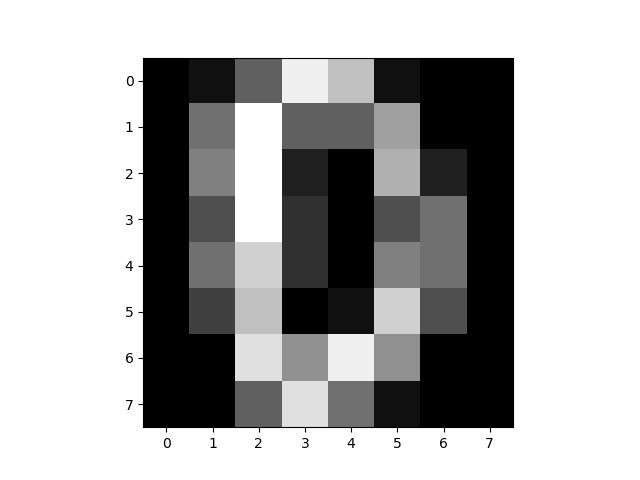

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21465ec8d68>)

In [34]:
file = open('Data/optdigits.tra', encoding ="utf8", errors = "ignore")
data = csv.reader(file)
lines = np.array(list(data))

X_input = np.array(lines[:,:-1], dtype = np.int)
Y_input = np.array(lines [:,-1:], dtype = np.int)

numCases = len (X)
numTags = len(np.unique(Y_input))

print (numTags)
#X matrix with normalized values from [0, 16] to [0.0, 1.0]

X_N = X_input/16.0

X_ones = np.hstack([np.ones((len(X), 1), dtype = np.int), X_input])
Y_real = np.zeros((numCases, numTags), dtype = np.int)
for n in range(numCases):
    Y_real[n][Y_input[n]] = 1
thetas1 = np.zeros()
    
    
displayImage(X_N[0])

We will be operating a 3 layer NN. 
- 1 input layer
- 1 hidden layer
- 1 output layer

# Anex
- How many hidden layers should my NN have?
http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-9.html
https://towardsdatascience.com/beginners-ask-how-many-hidden-layers-neurons-to-use-in-artificial-neural-networks-51466afa0d3e
- How many nodes should the hidden layer of my NN have?
http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html